In [2]:
# import stuff we need

%matplotlib inline

import math
import numpy as np
import pandas as pd
import seaborn as sns

import zlmdb
from cfxdb.schema import Schema

In [13]:
# attach to our crossbar event database
# when running notebook inside docker
DBFILE = '../testdb'

# when running notebook directly on host
DBFILE = '../../crossbar/.testdb'

db = zlmdb.Database(DBFILE, maxsize=2**30, readonly=False)
schema = Schema.attach(db)

# load our data into plain python lists
vec_x = []
vec_y = []
vec_category = []
vec_value2 = []

map_categories = {'null': 0, 'alert': 1, 'warning': 2, 'info': 3, 'ad': 4, 'other': 5}

with db.begin() as txn:
    i = 0
    # query event store and get geo events ..
    for pub in schema.publications.select(txn, limit=1000000-1, return_keys=False):
        if pub.topic.startswith('com.example.geoservice.'):
            e = pub.args[0]
            vec_x.append(e['x'])
            vec_y.append(e['y'])
            vec_category.append(map_categories.get(e['category'], 0))
            vec_value2.append(e['value2'])
        i += 1
        if i % 10000 == 0:
            print('processed {} records ..'.format(i))

print('finished: collected vectors of length {}'.format(len(vec_x)))

# create pandas dataframes from data collected in lists
df = pd.DataFrame({
    'x': np.asarray(vec_x, dtype='uint16'),
    'y': np.asarray(vec_y, dtype='uint16'),
    'category': np.asarray(vec_category, dtype='uint8'),
    'value2': np.asarray(vec_value2, dtype='float32')
})

# compute some basic statistics
df.describe()

finished: collected vectors of length 2853


,x,y,category,value2
count,2853.000000,2853.000000,2853.000000,2853.000000
mean,51.159832,50.298633,3.039607,0.491693
std,29.187472,29.284930,1.425883,0.288927
min,0.000000,0.000000,1.000000,0.000076
25%,27.000000,25.000000,2.000000,0.241620
50%,52.000000,50.000000,3.000000,0.487378
75%,76.000000,76.000000,4.000000,0.740377
max,100.000000,100.000000,5.000000,0.999934


In [14]:
# helper to truncate x/y coordinates
def trunc(val):
    return int(val / 20)

# apply truncate and compute aggregate
df2 = pd.DataFrame({
    'x': df['x'].apply(trunc),
    'y': df['y'].apply(trunc),
    'value': df['value2'],
}).pivot_table(index='x', columns='y', values='value', aggfunc=np.median)

df2

y,0,1,2,3,4,5
x,,,,,,
0,0.569726,0.486984,0.463975,0.458618,0.443541,0.849246
1,0.518156,0.488448,0.344061,0.412281,0.500171,0.407136
2,0.572369,0.450536,0.531439,0.515647,0.436585,0.746666
3,0.542668,0.474138,0.479702,0.545882,0.529725,0.391943
4,0.451923,0.579718,0.512896,0.533093,0.524437,0.401754
5,0.754856,0.821296,0.232540,0.593681,0.291027,NaN


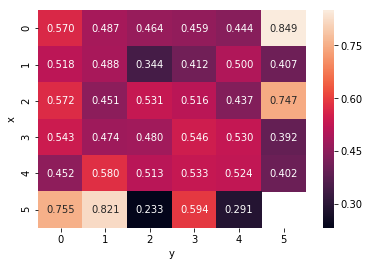

In [15]:
# draw heatmap
sns.heatmap(df2, annot=True, fmt=".3f")